## Task 1

In [35]:
"""
Initial DB Connection And Library Loading
"""
from sqlalchemy import create_engine, inspect
import json
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon
from geoalchemy2 import Geometry, WKTElement
import matplotlib.pyplot as plt
from shapely.wkt import loads
from sqlalchemy import text
import psycopg2
import psycopg2.extras
import numpy as np

credentials = "Credentials.json"

def pgconnect(credential_filepath, db_schema="public"):
    with open(credential_filepath) as f:
        db_conn_dict = json.load(f)
        host       = db_conn_dict["host"]
        db_user    = db_conn_dict["user"]
        db_pw      = db_conn_dict["password"]
        default_db = db_conn_dict["user"]
        port       = db_conn_dict["port"]
        try:
            db = create_engine(f"postgresql+psycopg2://{db_user}:{db_pw}@{host}:{port}/{default_db}", echo=False)
            conn = db.connect()
            print("Connected successfully.")
        except Exception as e:
            print("Unable to connect to the database.")
            print(e)
            db, conn = None, None
        return db,conn

def query(conn, sqlcmd, args=None, df=True):
    result = pd.DataFrame() if df else None
    try:
        if df:
            result = pd.read_sql_query(sqlcmd, conn, params=args)
        else:
            result = conn.execute(text(sqlcmd), args).fetchall()
            result = result[0] if len(result) == 1 else result
    except Exception as e:
        print("Error encountered: ", e, sep="\n")
    return result

In [36]:
db, conn = pgconnect(credentials)

Connected successfully.


In [37]:
"""
Loading In Datasets
"""

# Loading in SA2 dataset
sa2 = gpd.read_file("SA2/SA2_2021_AUST_GDA2020.shp")

# Loading in school dataset
future = gpd.read_file("catchments/catchments_future.shp")
primary = gpd.read_file("catchments/catchments_primary.shp")
secondary = gpd.read_file("catchments/catchments_secondary.shp")

# Loading in Businesses
businesses = pd.read_csv("Businesses.csv")

# Loading in Income
income = pd.read_csv("Income.csv")

# Loading in Polling Places
polling = pd.read_csv("PollingPlaces2019.csv")

# Loading in Populations
population = pd.read_csv("Population.csv")

# Loading in Stops
stop = pd.read_csv("Stops.txt")

In [38]:
"""
Data Cleaning
"""


"""
Helper Functions
"""
def lowercase_column_names(df):
    return df.rename(columns=lambda x: x.lower())

srid = 4326  # The chosen SRID for all datasets (the international SRID)
def create_wkt_element(geom, srid):
    if geom.geom_type == "Polygon":
        geom = MultiPolygon([geom])
    return WKTElement(geom.wkt, srid)
"""
END OF Helper Functions
"""


# Turning all column names to lowercase
sa2 = lowercase_column_names(sa2)
future = lowercase_column_names(future)
primary = lowercase_column_names(primary)
secondary = lowercase_column_names(secondary)
businesses = lowercase_column_names(businesses)
income = lowercase_column_names(income)
polling = lowercase_column_names(polling)
population = lowercase_column_names(population)
stop = lowercase_column_names(stop)


"""
sa2 File
"""
# Removing rows with invalid polygons
sa2 = sa2[sa2.geometry.is_valid]

# Removing rows where the GCC isn"t "Greater Sydney"
sa2 = sa2[sa2["gcc_name21"] == "Greater Sydney"]

# Polygons turned into multipolygons
sa2["geom"] = sa2["geometry"].apply(lambda x: create_wkt_element(geom=x,srid=srid))
sa2 = sa2.drop(columns="geometry")

# Renaming "sa2_code21" to "sa2_code"
sa2 = sa2.rename(columns={"sa2_code21": "sa2_code"})

# Renaming "sa2_name21" to "sa2_name"
sa2 = sa2.rename(columns={"sa2_name21": "sa2_name"})


"""
Catchment Files
"""
# Adding the priority column to the future table
future.insert(future.columns.get_loc("year12") + 1, "priority", "None")

# Changing all instances of "2024", "2025", "2026" and "2027" to "Y" and all instances of "0" to "N"
columns_to_replace = ["kindergart", "year1", "year2", "year3", "year4", "year5", "year6", "year7", "year8", "year9", "year10", "year11", "year12"]
future[columns_to_replace] = future[columns_to_replace].replace({2024: "Y", 2025: "Y", 2026: "Y", 2027: "Y", 0: "N"})

# Polygons turned into multipolygons
future["geom"] = future["geometry"].apply(lambda x: create_wkt_element(geom=x,srid=srid))
future = future.drop(columns="geometry")

primary["geom"] = primary["geometry"].apply(lambda x: create_wkt_element(geom=x,srid=srid))
primary = primary.drop(columns="geometry")

secondary["geom"] = secondary["geometry"].apply(lambda x: create_wkt_element(geom=x,srid=srid))
secondary = secondary.drop(columns="geometry")

# Joining "future", "primary" and "secondary" into one table namely "school"
school = pd.concat([future, primary, secondary], ignore_index=True)

# Turning the "add_date" column into a datetime datatype
school["add_date"] = pd.to_datetime(school["add_date"], format="%Y%m%d", errors="coerce")


"""
Business File
"""
# Recalculating the total_businesses column (some rows had been incorrectly summed)
business_sum = businesses.iloc[:, 4:9].sum(axis=1)
businesses["total_businesses"] = business_sum


"""
Income File
"""
# Removes any row whose column has "np"
income = income[income.apply(lambda row: "np" not in row.values, axis=1)]

# Renaming "sa2_code21" to "sa2_code"
income = income.rename(columns={"sa2_code21": "sa2_code"})

"""
Polling File
"""
# Removing all rows where the geom data is "NaN"
polling = polling.dropna(subset=["the_geom"])

# Renaming "the_geom" to "geom"
polling = polling.rename(columns={"the_geom": "geom"})

# Conversion to WKT format
polling["geom"] = polling["geom"].apply(lambda x: WKTElement(loads(x).wkt, srid=srid))


"""
Population File
"""
# Nothing modified in the population csv


"""
Stops File
"""
# Converting lat and long coordinates to a point object
stop["geom"] = gpd.points_from_xy(stop.stop_lat, stop.stop_lon)
stop["geom"] = stop["geom"].apply(lambda x: WKTElement(x.wkt, srid=srid))

In [39]:
"""
Table Creation
"""

# Creating the SA2 table
conn.execute(text("""
DROP TABLE IF EXISTS sa2;
CREATE TABLE sa2 (
    sa2_code NUMERIC, 
    sa2_name TEXT, 
    chg_flag21 NUMERIC, 
    chg_lbl21 TEXT, 
    sa3_code21 NUMERIC,
    sa3_name21 TEXT,
    sa4_code21 NUMERIC,
    sa4_name21 TEXT,
    gcc_code21 TEXT,
    gcc_name21 TEXT,
    ste_code21 NUMERIC,
    ste_name21 TEXT,
    aus_code21 TEXT,
    aus_name21 TEXT,
    areasqkm21 DOUBLE PRECISION,
    loci_uri21 TEXT,
    geom GEOMETRY(MULTIPOLYGON,4326),
    PRIMARY KEY (sa2_code)
);"""
))

# Creating the school table
conn.execute(text("""
DROP TABLE IF EXISTS school;
CREATE TABLE school (
    use_id NUMERIC,
    catch_type TEXT,
    use_desc TEXT,
    add_date TIMESTAMP,
    kindergart TEXT,
    year1 TEXT,
    year2 TEXT,
    year3 TEXT,
    year4 TEXT,
    year5 TEXT,
    year6 TEXT,
    year7 TEXT,
    year8 TEXT,
    year9 TEXT,
    year10 TEXT,
    year11 TEXT,
    year12 TEXT,
    priority TEXT,
    geom GEOMETRY(MULTIPOLYGON,4326),
    PRIMARY KEY (use_id, catch_type)
);"""
))

# Creating the businesses table
conn.execute(text("""
DROP TABLE IF EXISTS businesses;
CREATE TABLE businesses (
    industry_code TEXT,
    industry_name TEXT,
    sa2_code NUMERIC,
    sa2_name TEXT,
    "0_to_50k_businesses" NUMERIC,
    "50k_to_200k_businesses" NUMERIC,
    "200k_to_2m_businesses" NUMERIC,
    "2m_to_5m_businesses" NUMERIC,
    "5m_to_10m_businesses" NUMERIC,
    "10m_or_more_businesses" NUMERIC,
    total_businesses NUMERIC,
    PRIMARY KEY (industry_name, sa2_code)
);"""
))

# Creating the income table
conn.execute(text("""
DROP TABLE IF EXISTS income;
CREATE TABLE income (
    sa2_code NUMERIC,
    sa2_name TEXT,
    earners NUMERIC,
    median_age NUMERIC,
    median_income NUMERIC,
    mean_income NUMERIC,
    PRIMARY KEY (sa2_code)
);"""
))

# Creating the polling table
conn.execute(text("""
DROP TABLE IF EXISTS polling;
CREATE TABLE polling (
    fid TEXT,
    state TEXT,
    division_id NUMERIC,
    division_name TEXT,
    polling_place_id NUMERIC,
    polling_place_type_id NUMERIC,
    polling_place_name TEXT,
    premises_name TEXT,
    premises_address_1 TEXT,
    premises_address_2 TEXT,
    premises_address_3 TEXT,
    premises_suburb TEXT,
    premises_state_abbreviation TEXT,
    premises_postal_code NUMERIC,
    latitude DOUBLE PRECISION,
    longitude DOUBLE PRECISION,
    geom GEOMETRY(POINT,4326),
    PRIMARY KEY (fid)
);"""
))

# Creating the population table
conn.execute(text("""
DROP TABLE IF EXISTS population;
CREATE TABLE population (
    sa2_code NUMERIC,
    sa2_name TEXT,
    "0-4_people" NUMERIC,
    "5-9_people" NUMERIC,
    "10-14_people" NUMERIC,
    "15-19_people" NUMERIC,
    "20-24_people" NUMERIC,
    "25-29_people" NUMERIC,
    "30-34_people" NUMERIC,
    "35-39_people" NUMERIC,
    "40-44_people" NUMERIC,
    "45-49_people" NUMERIC,
    "50-54_people" NUMERIC,
    "55-59_people" NUMERIC,
    "60-64_people" NUMERIC,
    "65-69_people" NUMERIC,
    "70-74_people" NUMERIC,
    "75-79_people" NUMERIC,
    "80-84_people" NUMERIC,
    "85-and-over_people" NUMERIC,
    total_people NUMERIC,
    PRIMARY KEY (sa2_code)
);"""
))

# Creating the stop table
conn.execute(text("""
DROP TABLE IF EXISTS stop;
CREATE TABLE stop (
    stop_id NUMERIC,
    stop_code NUMERIC,
    stop_name TEXT,
    stop_lat DOUBLE PRECISION,
    stop_long DOUBLE PRECISION,
    location_type NUMERIC,
    parent_station NUMERIC,
    wheelchair_boarding NUMERIC,
    platform_code NUMERIC,
    geom GEOMETRY(POINT,4326),
    PRIMARY KEY (stop_id)
);"""
))

In [40]:
"""
Inserting Into SQL Tables
"""

sa2.to_sql("sa2", conn, if_exists="replace", index=False, dtype={"geom": Geometry("MULTIPOLYGON", srid)})
school.to_sql("school", conn, if_exists="replace", index=False, dtype={"geom": Geometry("MULTIPOLYGON", srid)})
businesses.to_sql("businesses", conn, if_exists="replace", index=False)
income.to_sql("income", conn, if_exists="replace", index=False)
polling.to_sql("polling", conn, if_exists="replace", index=False, dtype={"geom": Geometry("POINT", srid)})
population.to_sql("population", conn, if_exists="replace", index=False)
stop.to_sql("stop", conn, if_exists="replace", index=False, dtype={"geom": Geometry("POINT", srid)})

718

## Task 2

In [41]:
"""
Math functions
"""

def find_z_scores(array):
    mean = np.mean(array)
    std_dev = np.std(array)
    z_scores = (array - mean) / std_dev
    return z_scores

def per_thousand(num, num_people):
    return (num / num_people) * 1000

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [42]:
"""
List of business types, delete later
"""

businesses['industry_name'].unique()

array(['Agriculture, Forestry and Fishing', 'Mining', 'Manufacturing',
       'Electricity, Gas, Water and Waste Services', 'Construction',
       'Wholesale Trade', 'Retail Trade',
       'Accommodation and Food Services',
       'Transport, Postal and Warehousing',
       'Information Media and Telecommunications',
       'Financial and Insurance Services',
       'Rental, Hiring and Real Estate Services',
       'Professional, Scientific and Technical Services',
       'Administrative and Support Services',
       'Public Administration and Safety', 'Education and Training',
       'Health Care and Social Assistance',
       'Arts and Recreation Services', 'Other Services'], dtype=object)

In [43]:
sql = """
SELECT
    sa2_code,
    sa2_name,
    SUM(total_businesses) AS total_businesses
FROM
    businesses
WHERE
    industry_name IN ('Retail Trade', 'Construction',  'Accommodation and Food Services', 'Professional, Scientific and Technical Services', 'Education and Training', 'Health Care and Social Assistance')
GROUP BY
    sa2_code,
    sa2_name
ORDER BY
    sa2_code;
"""
businesses = query(conn, sql)
businesses
businesses.to_sql("businesses", conn, if_exists="replace", index=False)

643

In [44]:
"""
Total Number of businesses in each sa2 code, need to account for types of businesses soon
"""

sql = """
SELECT
    b.sa2_code,
    b.sa2_name,
    SUM(b.total_businesses) AS total_businesses,
    p.total_people
FROM
    businesses b
JOIN
    population p ON b.sa2_code = p.sa2_code
WHERE
    p.total_people >= 100
GROUP BY
    b.sa2_code,
    b.sa2_name,
    p.total_people
ORDER BY
    b.sa2_code;
"""

bus_info = query(conn, sql)

num_bus = bus_info['total_businesses']
num_ppl = bus_info['total_people']

bus_per_1000 = per_thousand(num_bus, num_ppl)
bus_info['num_businesses_per_1000'] = bus_per_1000

num_of_bus_array = bus_info['num_businesses_per_1000'].values
z_scores_bus = find_z_scores(num_of_bus_array)
bus_info['z_scores_businesses'] = z_scores_bus

num_businesses_sa2 = bus_info.drop(columns=['total_people', 'num_businesses_per_1000', 'sa2_name'])
num_businesses_sa2

,sa2_code,total_businesses,z_scores_businesses
0,102011028,502.0,0.042531
1,102011029,600.0,-0.088950
2,102011030,412.0,0.256110
3,102011031,1049.0,0.087116
4,102011032,1302.0,-0.017715
...,...,...,...
355,128021536,953.0,-0.208620
356,128021538,1136.0,-0.149257
357,128021607,708.0,-0.232882
358,128021608,299.0,-0.233739


In [45]:
"""
Number of stops in each sa2 region
"""

updating_stop = """
UPDATE stop
SET geom = ST_SetSRID(ST_MakePoint(stop_lon::float, stop_lat::float), 4326)::geometry;
"""
query(conn, updating_stop)

sql = """
SELECT
    CAST(sa2.sa2_code AS INTEGER) AS sa2_code,
    sa2.sa2_name,
    COUNT(stop.stop_id) AS num_of_stops
FROM
    sa2
LEFT JOIN
    stop ON ST_Contains(sa2.geom, stop.geom)
GROUP BY
    sa2.sa2_code,
    sa2.sa2_name
ORDER BY
    sa2.sa2_code;
"""
num_stops_sa2 = query(conn, sql)

num_of_stops_array = num_stops_sa2['num_of_stops'].values
z_scores_stops = find_z_scores(num_of_stops_array)

num_stops_sa2['z_scores_stops'] = z_scores_stops
# num_stops_sa2

Error encountered: 
This result object does not return rows. It has been closed automatically.


In [46]:
"""
Number of polling locations in each sa2 region
"""

updating_poll = """
UPDATE polling
SET geom = ST_SetSRID(ST_MakePoint(longitude::float, latitude::float), 4326)::geometry;
"""
query(conn, updating_poll)

sql = """
SELECT 
    CAST(sa2.sa2_code AS INTEGER) AS sa2_code,
    sa2.sa2_name, 
    sa2.gcc_name21,
    COUNT(polling.division_name) AS num_poll_stations
FROM 
    sa2 
LEFT JOIN 
    polling ON ST_Contains(sa2.geom, polling.geom)
GROUP BY 
    sa2.sa2_code,
    sa2.sa2_name,
    sa2.gcc_name21
ORDER BY 
    sa2.sa2_code;
"""
num_polls_sa2 = query(conn, sql)

num_of_polls_array = num_polls_sa2['num_poll_stations'].values
z_scores_polls = find_z_scores(num_of_polls_array)

num_polls_sa2['z_scores_polling'] = z_scores_polls
# num_polls_sa2

Error encountered: 
This result object does not return rows. It has been closed automatically.


In [47]:
"""
School catchments areas per 1000 ’young people’
"""

sql_pop = """
SELECT
    sa2_code,
    sa2_name,
    "0-4_people" + "5-9_people" + "10-14_people" + "15-19_people" AS "young_people",
    total_people
FROM
    population
WHERE
    total_people >= 100;
"""

sql_school = """
SELECT
    CAST(sa2.sa2_code AS INTEGER) AS sa2_code,
    sa2.sa2_name,
    COUNT(school.use_id) AS num_schools,
    SUM(ST_Area(school.geom)) AS total_area_schools
FROM
    sa2
LEFT JOIN
    school ON ST_Intersects(sa2.geom, school.geom)
GROUP BY
    sa2.sa2_code,
    sa2.sa2_name
ORDER BY
    num_schools DESC,
    sa2.sa2_code ASC;
"""

pop = query(conn, sql_pop)
sch = query(conn, sql_school)

num_schools_sa2_full = pd.merge(pop, sch, on='sa2_code', how='left')
num_schools_sa2_full = num_schools_sa2_full.drop(columns=['sa2_name_y', 'total_people'])
num_schools_sa2_full = num_schools_sa2_full.rename(columns={'sa2_name_x': 'sa2_name'})

area = num_schools_sa2_full['total_area_schools']
num_ppl = num_schools_sa2_full['young_people']
num_sch = num_schools_sa2_full['num_schools']

# catch_area_per_1000 = area_per_thousand(area, num_ppl)
# num_schools_sa2_full['catch_area_per_1000'] = catch_area_per_1000

num_per_1000 = per_thousand(num_sch, num_ppl)
num_schools_sa2_full['num_schools_per_1000'] = num_per_1000

catch_area_per_1000_array = num_schools_sa2_full['num_schools_per_1000'].values

z_scores_schools = find_z_scores(catch_area_per_1000_array)
num_schools_sa2_full['z_scores_schools'] = z_scores_schools

num_schools_sa2 = num_schools_sa2_full.drop(columns=['young_people', 'total_area_schools', 'num_schools_per_1000'])
num_schools_sa2_full
# num_schools_sa2

,sa2_code,sa2_name,young_people,num_schools,total_area_schools,num_schools_per_1000,z_scores_schools
0,102011028,Avoca Beach - Copacabana,2121,6,0.011371,2.828854,-0.264317
1,102011029,Box Head - MacMasters Beach,2471,7,0.029302,2.832861,-0.263670
2,102011030,Calga - Kulnura,961,26,0.742325,27.055151,3.646001
3,102011031,Erina - Green Point,3205,17,0.040830,5.304212,0.135225
4,102011032,Gosford - Springfield,4364,14,0.078641,3.208066,-0.203109
...,...,...,...,...,...,...,...
355,128021536,Oyster Bay - Como - Jannali,6212,13,0.004674,2.092724,-0.383135
356,128021538,Sutherland - Kirrawee,5078,17,0.008901,3.347775,-0.180559
357,128021607,Engadine,5118,11,0.023964,2.149277,-0.374006
358,128021608,Loftus - Yarrawarrah,2073,9,0.006854,4.341534,-0.020159


In [48]:
"""
Joining all dataframes into one
"""

joining = pd.merge(num_stops_sa2, num_polls_sa2, on='sa2_code', how='left')
joining = joining.drop(columns=['gcc_name21', 'sa2_name_y'])
joining = joining.rename(columns={'sa2_name_x': 'sa2_name'})

joining = pd.merge(num_schools_sa2, joining, on='sa2_code', how='left')
joining = joining.drop(columns=['sa2_name_y'])
joining = joining.rename(columns={'sa2_name_x': 'sa2_name'})

joining = pd.merge(joining, num_businesses_sa2, on='sa2_code', how='left')

In [49]:
"""
Calculating "Score" using the sigmoid function
"""

z_scores_df = joining.drop(columns=['num_schools', 'num_of_stops', 'num_poll_stations', 'total_businesses'])
z_scores_df['Score'] = sigmoid(z_scores_df['z_scores_schools'] + z_scores_df['z_scores_stops'] \
                                 + z_scores_df['z_scores_polling'] + z_scores_df['z_scores_businesses'])
# z_scores_df['Score'].values

## Task 3
### Hugh's dataset

In [50]:
"""
Converting json to dataframe
"""
        
def json_to_df(json_file):
    df = pd.read_json(json_file)
    return df

In [51]:
"""
Importing and cleaning up liquor file
"""

pubs = json_to_df('Liquor.json')

pubs['Latitude'] = pd.to_numeric(pubs['Latitude'], errors='coerce')
pubs['Longitude'] = pd.to_numeric(pubs['Longitude'], errors='coerce')

pubs["geom"] = gpd.points_from_xy(pubs.Latitude, pubs.Longitude)
pubs["geom"] = pubs["geom"].apply(lambda x: WKTElement(x.wkt, srid=srid))

pubs = pubs.loc[:, ['SA2', 'Licence name', 'Licence type', 'Status', 'Trading Status', 'Latitude', 'Longitude', 'geom']]
pubs = pubs.rename(columns={"SA2": "sa2 name", "Latitude": "venues_lat", "Longitude": "venues_long"})

pubs = lowercase_column_names(pubs)
pubs = pubs.rename(columns=lambda x: x.replace(" ", "_"))

In [52]:
"""
Creating the pubs table
"""

conn.execute(text("""
DROP TABLE IF EXISTS pubs;
CREATE TABLE pubs (
    sa2_name TEXT, 
    licence_name TEXT, 
    licence_number NUMERIC, 
    licence_type TEXT, 
    status TEXT, 
    trading_status TEXT,
    venues_lat DOUBLE PRECISION,
    venues_long DOUBLE PRECISION,
    geom GEOMETRY(POINT,4326),
    PRIMARY KEY (licence_number)
);
"""))



"""
Inserting in sql
"""

pubs.to_sql("pubs", conn, if_exists="replace", index=False, dtype={"geom": Geometry("POINT", srid)})

123

In [53]:
sql = """
select * from pubs
WHERE
    pubs.status = 'Current'
    AND pubs.trading_status = 'Trading'
    AND pubs.licence_type <> 'Liquor - packaged liquor licence';
"""
pubs = query(conn, sql)

In [54]:
"""
Collecting information and z-scores
"""

updating_pubs = """
UPDATE pubs
SET geom = ST_SetSRID(ST_MakePoint(venues_long::float, venues_lat::float), 4326)::geometry;
"""
query(conn, updating_pubs)

# Accounting for suspended licences, currently trading venues and does not include bottleshops, supermarkets, etc...
# Only includes venues such as pubs, bar and hotels, e.g. venues
sql = """
SELECT
    CAST(sa2.sa2_code AS INTEGER) AS sa2_code,
    sa2.sa2_name,
    COUNT(pubs.licence_name) AS num_of_venues
FROM
    sa2
LEFT JOIN
    pubs ON ST_Contains(sa2.geom, pubs.geom)
GROUP BY
    sa2.sa2_code,
    sa2.sa2_name
ORDER BY
    sa2.sa2_code;
"""

venues = query(conn, sql)

venues
venues.to_sql("venues", conn, if_exists="replace", index=False, dtype={"geom": Geometry("POINT", srid)})

Error encountered: 
This result object does not return rows. It has been closed automatically.


373

In [55]:
num_of_venues_array = venues['num_of_venues'].values
z_scores_venues = find_z_scores(num_of_venues_array)

venues['z_scores_venues'] = z_scores_venues

In [56]:
"""
Adjust Venues to only be sa2 regions with 100 people
"""

sql = """
SELECT sa2_code
FROM population
WHERE
    total_people >= 100
"""
min_people = query(conn, sql)
venues = pd.merge(venues, min_people, on='sa2_code', how='left')

In [57]:
"""
Adding venues z-scores into the dataframe
"""

z_sch_df = num_schools_sa2.drop(columns=['num_schools'])
z_stop_df = num_stops_sa2.loc[:, ['sa2_code', 'z_scores_stops']]
z_poll_df = num_polls_sa2.loc[:, ['sa2_code', 'z_scores_polling']]
z_bus_df = num_businesses_sa2.drop(columns=['total_businesses'])
z_ven_df = venues.drop(columns=['sa2_name', 'num_of_venues'])

merged_df = z_sch_df.merge(z_stop_df, on='sa2_code', how='left') \
                   .merge(z_poll_df, on='sa2_code', how='left') \
                   .merge(z_bus_df, on='sa2_code', how='left') \
                   .merge(z_ven_df, on='sa2_code', how='left')

merged_df['Score'] = sigmoid(merged_df['z_scores_schools'] + merged_df['z_scores_stops'] +
                             merged_df['z_scores_polling'] + merged_df['z_scores_businesses'] + merged_df['z_scores_venues'])


In [58]:
merged_df

,sa2_code,sa2_name,z_scores_schools,z_scores_stops,z_scores_polling,z_scores_businesses,z_scores_venues,Score
0,102011028,Avoca Beach - Copacabana,-0.264317,-0.258474,-0.502168,0.042531,-0.170469,0.239960
1,102011029,Box Head - MacMasters Beach,-0.263670,0.759299,-0.502168,-0.088950,-0.232042,0.418841
2,102011030,Calga - Kulnura,3.646001,0.261978,0.710971,0.256110,-0.232042,0.990463
3,102011031,Erina - Green Point,0.135225,1.568892,0.468343,0.087116,0.342644,0.931004
4,102011032,Gosford - Springfield,-0.203109,2.378484,0.710971,-0.017715,0.732609,0.973435
...,...,...,...,...,...,...,...,...
355,128021536,Oyster Bay - Como - Jannali,-0.383135,1.210358,0.710971,-0.208620,-0.026797,0.786302
356,128021538,Sutherland - Kirrawee,-0.180559,0.527987,0.468343,-0.149257,0.506840,0.763751
357,128021607,Engadine,-0.374006,0.828693,0.710971,-0.232882,-0.067846,0.703689
358,128021608,Loftus - Yarrawarrah,-0.020159,-0.061859,-0.502168,-0.233739,-0.478336,0.214795


In [59]:
sql = """
SELECT sa2_code, CAST(median_income AS FLOAT) AS median_income
FROM income
"""
income = query(conn, sql)
income = pd.merge(min_people, income, on='sa2_code', how='left')

score_and_income = pd.merge(merged_df, income, on='sa2_code', how='left')

In [75]:
score_and_income

,sa2_code,sa2_name,z_scores_schools,z_scores_stops,z_scores_polling,z_scores_businesses,z_scores_venues,Score,median_income
0,102011028,Avoca Beach - Copacabana,-0.264317,-0.258474,-0.502168,0.042531,-0.170469,0.239960,55065.0
1,102011029,Box Head - MacMasters Beach,-0.263670,0.759299,-0.502168,-0.088950,-0.232042,0.418841,51927.0
2,102011030,Calga - Kulnura,3.646001,0.261978,0.710971,0.256110,-0.232042,0.990463,49168.0
3,102011031,Erina - Green Point,0.135225,1.568892,0.468343,0.087116,0.342644,0.931004,51905.0
4,102011032,Gosford - Springfield,-0.203109,2.378484,0.710971,-0.017715,0.732609,0.973435,54372.0
...,...,...,...,...,...,...,...,...,...
355,128021536,Oyster Bay - Como - Jannali,-0.383135,1.210358,0.710971,-0.208620,-0.026797,0.786302,67381.0
356,128021538,Sutherland - Kirrawee,-0.180559,0.527987,0.468343,-0.149257,0.506840,0.763751,64940.0
357,128021607,Engadine,-0.374006,0.828693,0.710971,-0.232882,-0.067846,0.703689,63695.0
358,128021608,Loftus - Yarrawarrah,-0.020159,-0.061859,-0.502168,-0.233739,-0.478336,0.214795,63087.0


In [61]:
scores = score_and_income['Score']
median_incomes = score_and_income['median_income']

correlation_matrix = np.corrcoef(scores, median_incomes)
correlation_matrix[0,1]

0.12630598547987992

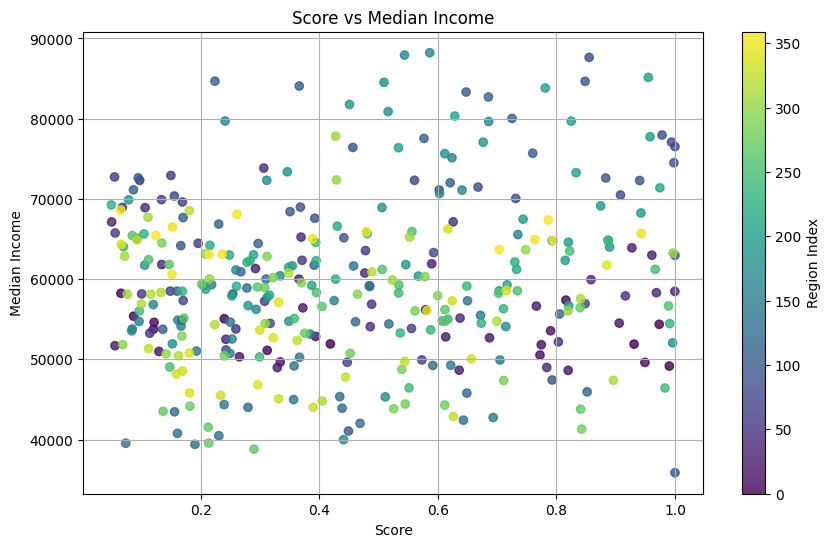

In [62]:
data = score_and_income

# Plot the data
plt.figure(figsize=(10, 6))
plt.scatter(data['Score'], data['median_income'], c=data.index, cmap='viridis', alpha=0.8)

plt.xlabel('Score')
plt.ylabel('Median Income')
plt.title('Score vs Median Income')
plt.colorbar(label='Region Index')
plt.grid(True)
plt.show()


In [76]:
sa2_regions = gpd.read_file('SA2_2021_AUST_SHP_GDA2020/SA2_2021_AUST_GDA2020.shp')
sa2_regions = lowercase_column_names(sa2_regions)
sa2_regions = sa2_regions.rename(columns={"sa2_code21": "sa2_code"})
# sa2_regions

In [77]:
merged_df = pd.merge(sa2_regions, sa2, on="sa2_code", how="inner")
edited_df = merged_df.loc[:, ['sa2_code', 'sa2_name21', 'geometry', 'geom']]

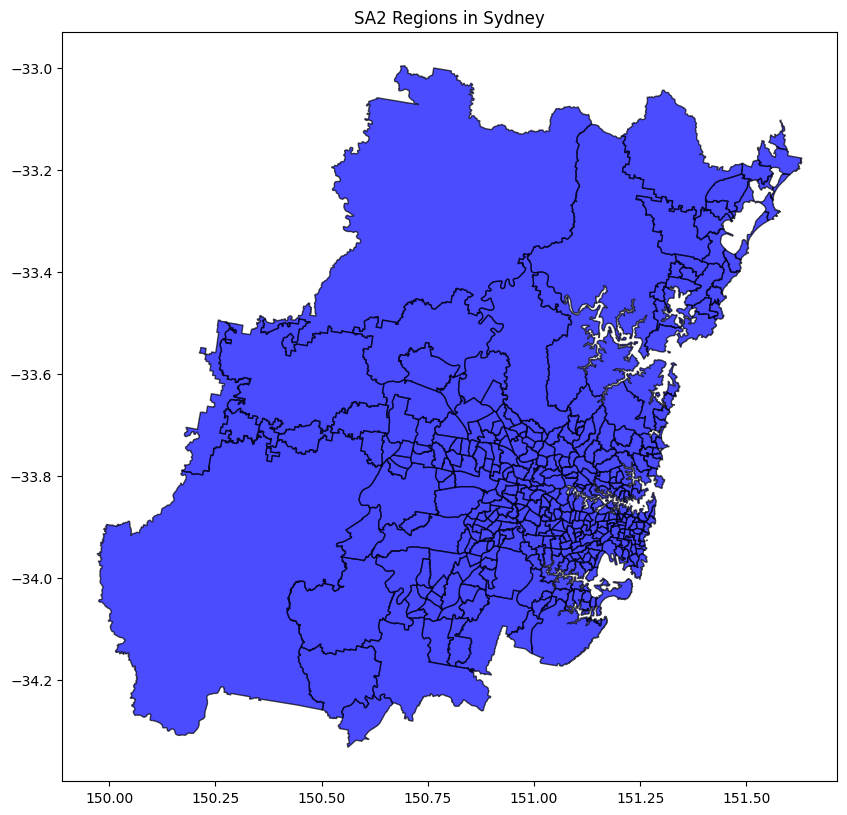

In [78]:
fig, ax = plt.subplots(figsize=(10, 10))
edited_df.plot(ax=ax, color='blue', alpha=0.7, edgecolor='black')

# Set title and display the plot
ax.set_title('SA2 Regions in Sydney')
plt.show()

In [79]:
edited_df['sa2_code'] = edited_df['sa2_code'].astype(int)

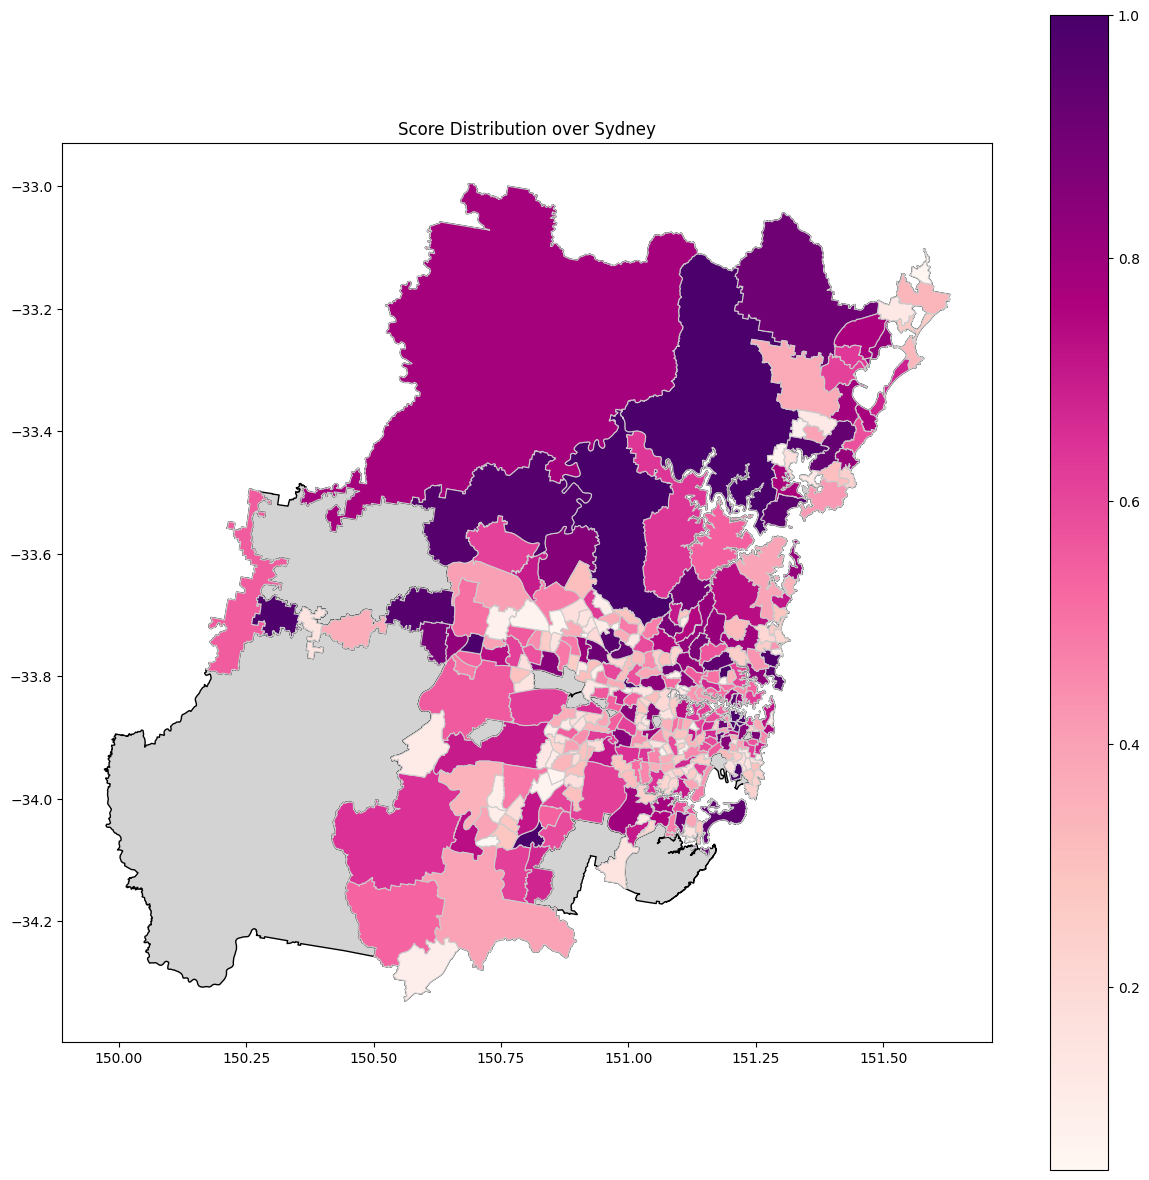

In [80]:
fig, ax = plt.subplots(figsize=(15, 15))
edited_df.plot(ax=ax, color='lightgrey', edgecolor='black')

merged_data = pd.merge(edited_df, score_and_income, on='sa2_code', how='inner').drop(columns=['sa2_name']).rename(columns={'sa2_name21': 'sa2_name'})

merged_data.plot(column='Score', cmap='RdPu', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
plt.title('Score Distribution over Sydney')
plt.show()



## Task 3
### Shane's dataset

In [34]:
conn.close()
db.dispose()